# Step-by-Step Guide: Using Expected Value (EV) with Predictive Probabilities

## Step 1: What is Expected Value (EV)?
> The Expected Value framework helps you make rational decisions when outcomes are uncertain.

Mathematically:
$$
EV = \sum_{i=1}^{n} P(\text{Outcome}_i) \times \text{Value}(\text{Outcome}_i)
$$

- $P(\text{Outcome}_i)$ = probability of a possible outcome
- $\text{Value}(\text{Outcome}_i$) = payoff (e.g., profit, revenue, customer adoption) of that outcome
- Sum across all possible outcomes
- → It’s a weighted average of possible future scenarios.

**Intuition**: If you could repeat the decision **many times**, EV is the average payoff you’d get.

## Step 2: How is it used?
- **Business Strategy**: deciding whether to launch a feature, enter a market, or acquire a company.
- **Product Decisions**: assessing impact of a new feature vs. risks of failure.
- **Finance / Betting**: pricing, investments, insurance.

In all cases → you’re asking: “What’s the average outcome if I consider both risk and reward?”

## Step 3: Business Challenge Example — New Product Feature
Imagine you’re a product manager considering launching a **“1-click checkout” feature**.
Assign a $ value to each outcome, including costs and risks.

**Example Possible Scenarios:**
1. Big Success: Feature drives adoption → +$2M profit. (probability: 0.3)
2. Moderate Success: Some adoption → +$500k profit. (probability: 0.4)
3. Failure: Feature confuses users, causes churn → -$1M loss. (probability: 0.3)

### Sources of Probabilities
There are several ways to estimate probabilities for business outcomes:
1. **Historical Data:**
- Look at similar past product launches.
- Example: 25% failed, 50% modest success, 25% big success.
2. **Market Experiments / A/B Tests:**
- Launch to a subset of users → measure conversion/churn impact.
- Probabilities are empirical frequencies from test results.
3. **Expert Judgment / Bayesian Priors:**
- When no data is available, experts provide priors, updated with evidence later.
4. **Predictive Modeling**:
- Train a model to predict the probability of success/failure given features (customer base, product type, launch conditions).
- Use holdout/test data → estimated probabilities.

## Step 4: EV Calculation
$EV=(0.3×2M)+(0.4×0.5M)+(0.3×−1M)EV=0.6M+0.2M−0.3M=0.5MEV=0.6M+0.2M−0.3M=0.5M$

**The Expected Value = +$500k
Meaning: On average, this launch is expected to create $500k in value.**

## Step 5: How do you assess if it’s a “good model”?
- ✅ Input Quality: Are probabilities & payoffs based on real data (A/B test, surveys, market research)?
- ✅ Sensitivity Analysis: How does EV change if assumptions shift (e.g., failure chance is higher)?
- ✅ Decision Context: Even if EV is positive, can your business absorb the downside risk?

> EV gives you the average rational choice, but risk appetite and strategic fit still matter.

## Example — Using a Model to Estimate Probabilities
Let’s imagine you have historical product launches with features like:
* Marketing spend
* Product complexity
* Team size
* Market segment

And an outcome label: **success (1) / failure (0).**

We can train a **logistic regression** to predict the probability of success for a new launch:

1. **Train a model on past launches** → predicts probability of success.
2. **Validate it on holdout data** (ROC-AUC tells us predictive power).
3. **Use the predicted probability** for a new feature in the Expected Value calculation.

→ This way, probabilities are not guesses — they’re grounded in data.

### Part A: Binary outcome model -> EV


=== PART A: Binary Outcome Model ===
ROC-AUC (binary, holdout): 0.83
Predicted P(success): 92.41%
EV (binary): $1,772,288


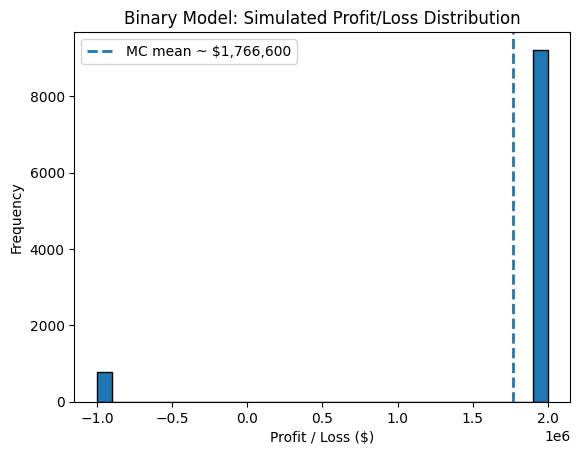

In [1]:
"""
Expected Value (EV) Decision Framework — End-to-End, with Modeling for Probabilities

This script shows two paths:
A) Binary outcome model -> EV
B) Multiclass outcome model (Failure / Moderate / Big success) -> EV

It uses synthetic data so you can run it anywhere.

How to use:
- Run top-to-bottom
- Inspect printed metrics to judge model quality (AUC/log-loss/accuracy/Brier)
- Study the plots to understand uncertainty and sensitivity
"""

# -----------------------------
# Imports
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
roc_auc_score, log_loss, accuracy_score, brier_score_loss, confusion_matrix
)

np.random.seed(42)

# Utility helper

def ev_from_probs(prob_vec, values_vec):
    """
    Compute expected value from a probability vector and value vector.
    prob_vec: shape (k,) class probabilities summing to 1
    values_vec: shape (k,) payoff per class aligned with prob_vec
    """
    prob_vec = np.asarray(prob_vec)
    values_vec = np.asarray(values_vec)
    return float(np.sum(prob_vec * values_vec))

# -----------------------------
# PART A — Binary outcome model: Success (1) vs Failure (0)
# -----------------------------
print("\n=== PART A: Binary Outcome Model ===")

n = 500
marketing_spend = np.random.normal(100, 20, n)
complexity = np.random.randint(1, 5, n) # 1=low, 4=high
team_size = np.random.randint(3, 20, n)

# True success probability (synthetic ground truth)
true_prob_bin = 1 / (1 + np.exp(-(0.05*marketing_spend - 0.8*complexity + 0.1*team_size - 3)))
success = np.random.binomial(1, true_prob_bin)

bin_df = pd.DataFrame({
'marketing_spend': marketing_spend,
'complexity': complexity,
'team_size': team_size,
'success': success
})

X = bin_df[['marketing_spend', 'complexity', 'team_size']]
y = bin_df['success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

bin_model = LogisticRegression(max_iter=1000)
bin_model.fit(X_train, y_train)

bin_proba_test = bin_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, bin_proba_test)
print(f"ROC-AUC (binary, holdout): {auc:.2f}")

# Predict for a candidate launch and compute EV
candidate = pd.DataFrame({'marketing_spend':[120], 'complexity':[2], 'team_size':[10]})
prob_success = float(bin_model.predict_proba(candidate)[0, 1])
values_bin = np.array([-1_000_000, 2_000_000]) # [Failure(0), Success(1)] payoffs
EV_bin = ev_from_probs([1 - prob_success, prob_success], values_bin)
print(f"Predicted P(success): {prob_success:.2%}")
print(f"EV (binary): ${EV_bin:,.0f}")

# Visualize distribution of binary outcomes (Monte Carlo from model prob)
mc_samples = 10000
outcomes_bin = np.random.choice([values_bin[0], values_bin[1]], size=mc_samples, p=[1-prob_success, prob_success])
plt.figure()
plt.hist(outcomes_bin, bins=30, edgecolor='black')
plt.axvline(np.mean(outcomes_bin), linestyle='dashed', linewidth=2, label=f'MC mean ~ ${np.mean(outcomes_bin):,.0f}')
plt.title("Binary Model: Simulated Profit/Loss Distribution")
plt.xlabel("Profit / Loss ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Part B: Binary outcome model -> EV

**Make the decision with guardrails**
- Rule of thumb: Launch if EV > 0 and downside risk is tolerable.
- Add thresholds:
  - EV must exceed $X
  - Probability of loss must be < Y%

**Sensitivity analysis**
- Vary key drivers (marketing spend, complexity, team size).
- Plot how EV changes.
- Identify thresholds: e.g., “Need ≥ $120k marketing spend for EV > 0.”

**Implement & monitor**
- If launching/piloting: track leading indicators and outcomes.
- Feed real results back into the dataset for continuous model improvement.

In [17]:
y_onehot

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], shape=(360, 3))


=== PART B: Multiclass Outcome Model ===
Accuracy (multiclass, holdout): 0.73
Log-loss   (multiclass, holdout): 0.736
Brier score(multiclass, holdout): 0.422


/Volumes/cmnoyk SSD/CODE/_GIT-Repos/DATA-TEMPLATE/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


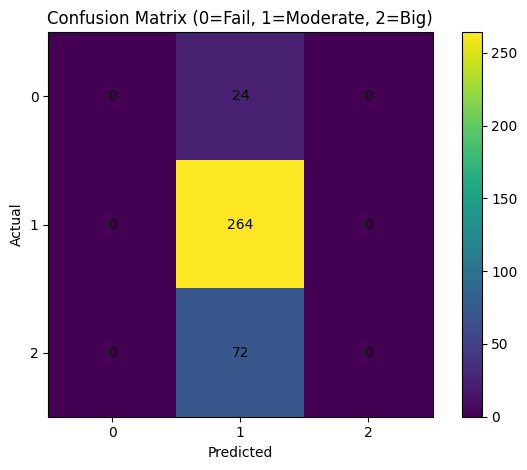

Class probabilities (candidate) [Fail,Moderate,Big]: [0.034 0.661 0.305]
EV (multiclass): $905,252


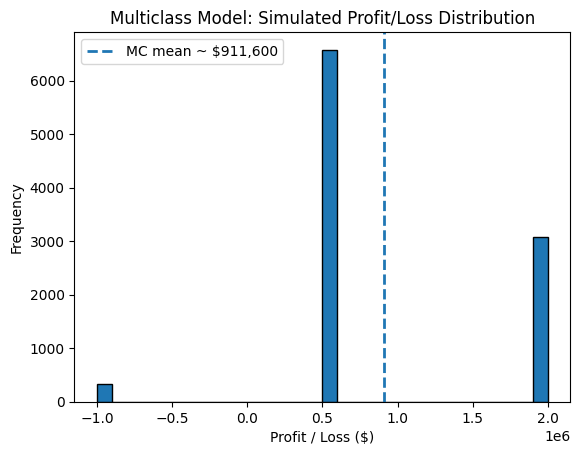

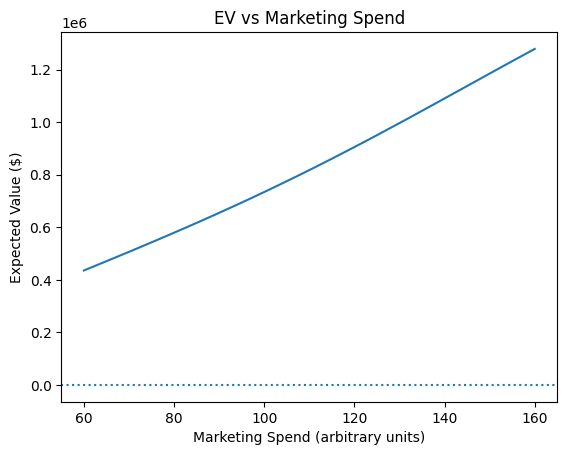

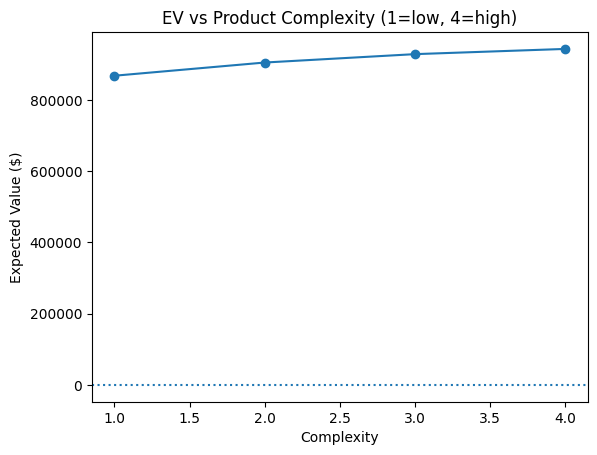

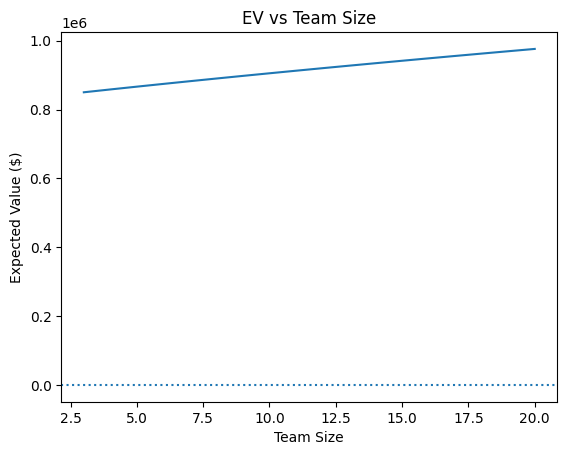


Done. Use the sensitivity plots to set decision thresholds (e.g., minimum spend for EV>0).


In [ ]:
# -----------------------------
# PART B — Multiclass model: 0=Failure, 1=Moderate, 2=Big success
# -----------------------------
print("\n=== PART B: Multiclass Outcome Model ===")

n = 1200
marketing_spend = np.random.normal(100, 22, n)
complexity = np.random.randint(1, 5, n)
team_size = np.random.randint(3, 22, n)
segment = np.random.choice([0,1], size=n)  # two market segments

# Construct class scores (synthetic). Higher marketing_spend and team_size help; complexity hurts.
# Segment 1 is a bit more responsive than segment 0.
score_fail =  -1.5 - 0.6*complexity + 0.02*(marketing_spend-100) - 0.02*(team_size-10) - 0.2*segment
score_mod  =  -0.3 - 0.2*complexity + 0.03*(marketing_spend-100) + 0.02*(team_size-10) + 0.1*segment
score_big  =  -2.0 - 0.1*complexity + 0.05*(marketing_spend-100) + 0.04*(team_size-10) + 0.3*segment

# Softmax to get class probabilities
scores = np.vstack([score_fail, score_mod, score_big]).T
scores_exp = np.exp(scores - scores.max(axis=1, keepdims=True))
probs = scores_exp / scores_exp.sum(axis=1, keepdims=True)  # shape (n,3)

# Sample class label per row
# For each simulated launch, draw an outcome label (0,1,2) based on the class probabilities for that launch.
labels = np.array([0,1,2]) # 0 = Failure, 1 = Moderate success, 2 = Big success
y_mc = np.array([np.random.choice(labels, p=p) for p in probs])

mc_df = pd.DataFrame({
    'marketing_spend': marketing_spend,
    'complexity': complexity,
    'team_size': team_size,
    'segment': segment,
    'outcome': y_mc
})

# Train/test split and multinomial logistic regression
X = mc_df[['marketing_spend', 'complexity', 'team_size', 'segment']]
y = mc_df['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

mc_model = LogisticRegression(max_iter=2000, multi_class='multinomial')
mc_model.fit(X_train, y_train)

proba_test = mc_model.predict_proba(X_test)
pred_test = mc_model.predict(X_test)

# Metrics
acc = accuracy_score(y_test, pred_test)
ll = log_loss(y_test, proba_test)

# Multiclass Brier score: average of per-class Brier components
# Expand y_test to one-hot
k = proba_test.shape[1]
y_onehot = np.eye(k)[y_test]
brier = np.mean(np.sum((proba_test - y_onehot)**2, axis=1))

print(f"Accuracy (multiclass, holdout): {acc:.2f}")
print(f"Log-loss   (multiclass, holdout): {ll:.3f}")
print(f"Brier score(multiclass, holdout): {brier:.3f}")

# Confusion matrix plot
cm = confusion_matrix(y_test, pred_test, labels=[0,1,2])
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (0=Fail, 1=Moderate, 2=Big)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.xticks([0,1,2],[0,1,2])
plt.yticks([0,1,2],[0,1,2])
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

# EV mapping for the three outcomes
# - If the launch fails, we lose $1M.
# - If it’s a moderate success, we gain $0.5M.
# - If it’s a big success, we gain $2M.
values_mc = np.array([
    -1_000_000,  # 0: Failure
    500_000,     # 1: Moderate success
    2_000_000    # 2: Big success
])

# For this specific launch configuration (marketing spend = 120, complexity = 2, etc.)
# Predict probabilities for a candidate configuration...
candidate_mc = pd.DataFrame({
    'marketing_spend':[120],
    'complexity':[2],
    'team_size':[10],
    'segment':[1]
})
probs_candidate = mc_model.predict_proba(candidate_mc)[0]
# ...and compute EV...
EV_mc = ev_from_probs(probs_candidate, values_mc)
print(f"Class probabilities (candidate) [Fail,Moderate,Big]: {np.round(probs_candidate,3)}")
print(f"EV (multiclass): ${EV_mc:,.0f}")

# Monte Carlo distribution of outcomes for this candidate
# (Instead of just computing the average, we simulate 10,000 launches)
# - In ~25% of cases, you see -$1M
# - In ~50% of cases, you see +$0.5M
# - In ~25% of cases, you see +$2M
# This gives a distribution of possible outcomes.
mc_outcomes = np.random.choice(values_mc, size=10000, p=probs_candidate)
plt.figure()
plt.hist(mc_outcomes, bins=30, edgecolor='black')
plt.axvline(np.mean(mc_outcomes), linestyle='dashed', linewidth=2, label=f'MC mean ~ ${np.mean(mc_outcomes):,.0f}')
plt.title("Multiclass Model: Simulated Profit/Loss Distribution")
plt.xlabel("Profit / Loss ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# -----------------------------
# Sensitivity Analysis: How EV changes with features
# -----------------------------

# 1) Marketing spend sweep
spend_range = np.linspace(60, 160, 50)
ev_spend = []
for s in spend_range:
    row = pd.DataFrame({'marketing_spend':[s], 'complexity':[2], 'team_size':[10], 'segment':[1]})
    p = mc_model.predict_proba(row)[0]
    ev_spend.append(ev_from_probs(p, values_mc))
ev_spend = np.array(ev_spend)
plt.figure()
plt.plot(spend_range, ev_spend)
plt.axhline(0, linestyle='dotted')
plt.title("EV vs Marketing Spend")
plt.xlabel("Marketing Spend (arbitrary units)")
plt.ylabel("Expected Value ($)")
plt.show()

# 2) Complexity sweep
complexity_vals = np.arange(1,5)
ev_complexity = []
for c in complexity_vals:
    row = pd.DataFrame({'marketing_spend':[120], 'complexity':[int(c)], 'team_size':[10], 'segment':[1]})
    p = mc_model.predict_proba(row)[0]
    ev_complexity.append(ev_from_probs(p, values_mc))
ev_complexity = np.array(ev_complexity)
plt.figure()
plt.plot(complexity_vals, ev_complexity, marker='o')
plt.axhline(0, linestyle='dotted')
plt.title("EV vs Product Complexity (1=low, 4=high)")
plt.xlabel("Complexity")
plt.ylabel("Expected Value ($)")
plt.show()

# 3) Team size sweep
team_vals = np.arange(3,21)
ev_team = []
for t in team_vals:
    row = pd.DataFrame({'marketing_spend':[120], 'complexity':[2], 'team_size':[int(t)], 'segment':[1]})
    p = mc_model.predict_proba(row)[0]
    ev_team.append(ev_from_probs(p, values_mc))
ev_team = np.array(ev_team)
plt.figure()
plt.plot(team_vals, ev_team)
plt.axhline(0, linestyle='dotted')
plt.title("EV vs Team Size")
plt.xlabel("Team Size")
plt.ylabel("Expected Value ($)")
plt.show()

print("\nDone. Use the sensitivity plots to set decision thresholds (e.g., minimum spend for EV>0).")
zip()